In [1]:
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
def format_time(time):
  """ Returns a time with format HH:MM:SS from numeric time value, in seconds """
  m, s = divmod(time, 60)
  h, m = divmod(m, 60)
  return f"{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}"

# ITCH

ITCH, shorthand for TotalView-ITCH, is Nasdaq's direct data-feed reporting protocol. It allows subscribers to track individual orders from placement to execution or cancellation. With proper parsing, it allows reconstruction of the order book. Being able to read ITCH data is invaluable for algorithmic trading.

So that's what we are going to work on today.

Check the TotalView-ITCH documentation here:
https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHSpecification.pdf

#### Set Data Paths

In [3]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

In [4]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

#### Download and Unzip

In [5]:
def download(url):
  """ Download and unzip ITCH data, if available """

  # create directory if we need to
  if not data_path.exists():
    data_path.mkdir()
    print('Directory Created')
  else:
    print('Directory Already Exists')

  filename = data_path / url.split('/')[-1]

  # Download file if need be
  if not filename.exists():
    print('Downloading file...', url)
    urlretrieve(url, filename)
  else:
    print('File already downloaded')

  unzipped = data_path / (filename.stem + '.bin')

  # unzip feel if need be
  if not unzipped.exists():
    print('Unzipping to', unzipped)
    with gzip.open(str(filename), 'rb') as f_in:
      with open(unzipped, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
  else:
    print('File already unzipped')
  
  return unzipped

In [6]:
file_name = download(urljoin(FTP_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Directory Created
Unzipping to data/10302019.NASDAQ_ITCH50.bin


## Processing the file

The ITCH data is in a binary file, but thankfully Python has the `struct` module to help us parse the information. 

I highly recommend taking a look at the module documentation here: 
https://docs.python.org/3/library/struct.html

### Creating Formatting Dictionaries

We will use a few dictionaries to "translate" the ITCH data into something we can more easily read and understand.

In [7]:
event_codes = {'O':'Start of Messages',
               'S':'Start of System Hours',
               'Q':'Start of Market Hours',
               'M':'End of Market Hours',
               'E':'End of System Hours',
               'C':'End of Messages'}

In [8]:
variable_encoding = {'primary_market_maker': {'Y':1, 'N':0},
                     'printable': {'Y':1, 'N':0},
                     'buy_sell_indicator': {'B':1, 'S':-1},
                     'cross_type': {'O':0, 'C':1, 'H':2},
                     'imbalance_direction': {'B':0, 'S':1, 'N':0, 'O':-1}}

In [9]:
formatting_dict = {
    ('integer', 2):'H',
    ('integer', 4):'I',
    ('integer', 6):'6s',
    ('integer', 8):'Q',

    ('alpha', 1):'s',
    ('alpha', 2):'2s',
    ('alpha', 4):'4s',
    ('alpha', 8):'8s',

    ('price_4', 4):'I',
    ('price_8', 8):'Q'
}

### Message Types

There are many different message types in ITCH, and the protocol includes an encoding system for the different types. It is a pretty long list...but thankfully, Stefan Jansen or one of his collaborators has taken on the tedious task of putting the codes into a .xlsx file for us. 

Get the file here:
https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/02_market_and_fundamental_data/01_NASDAQ_TotalView-ITCH_Order_Book/message_types.xlsx



In [10]:
message_types = pd.read_excel('message_types.xlsx', sheet_name='messages')
message_types = message_types.sort_values('id').drop('id', axis=1)
message_types.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


#### Clean the message_types Data

In [11]:
def clean_message_types(data):
  """ Cleans up the message_types DataFrame, making it easier to work with in Python """
  data.columns = [c.lower().strip() for c in data.columns]
  data.value = data.value.str.strip()
  data.name = (data.name.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_'))
  data.notes = data.notes.str.strip()
  data['message_type'] = data.loc[data.name == 'message_type', 'value']
  
  return data

In [12]:
message_types = clean_message_types(message_types)

In [13]:
message_types.head()

,name,offset,length,value,notes,message_type
0,message_type,0,1,S,System Event Message,S
1,stock_locate,1,2,Integer,Always 0,NaN
2,tracking_number,3,2,Integer,Nasdaq internal tracking number,NaN
3,timestamp,5,6,Integer,Nanoseconds since midnight,NaN
4,event_code,11,1,Alpha,See System Event Codes below,NaN


We are also going to extract the message_types so we can easily replace them with message_labels to make it more readable.

In [14]:
message_labels = message_types.loc[:, ['message_type', 'notes']].dropna()
message_labels.columns = ['message_type', 'name']
message_labels.name = message_labels.name.str.lower().str.replace('message', '').str.replace('.', '').str.strip().str.replace(' ', '_')
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


### Finalize Message Types

In [15]:
message_types['message_type'] = message_types['message_type'].ffill()
message_types = message_types[message_types['name'] != 'message_type']
message_types['value'] = message_types['value'].str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [16]:
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


### Save Cleaned message_types DataFrame to .csv file

In [17]:
#message_types.to_csv('clean_message_types.csv', index=False)

In [18]:
message_types = pd.read_csv('clean_message_types.csv')

## Use message_types to format ITCH data!

In [19]:
# create format tuples
format_tuples = message_types[['value', 'length']].apply(tuple, axis=1).map(formatting_dict)
format_tuples

0       H
1       H
2      6s
3       s
4       H
       ..
147     I
148     I
149     I
150     s
151     s
Length: 152, dtype: object

In [20]:
message_types['format'] = format_tuples
alphas = message_types[message_types['value'] == 'alpha']
alphas = alphas.set_index('name')
alphas_grouped = alphas.groupby('message_type')
alphas_formats = {k:v.to_dict() for k, v in alphas_grouped['format']}
alphas_lengths = {k:v.add(5).to_dict() for k, v in alphas_grouped['length']}

In [21]:
# create message classes
message_classes, fstrings = {}, {}
for t, message in message_types.groupby('message_type'):
  message_classes[t] = namedtuple(typename=t, field_names=message['name'].tolist())
  fstrings[t] = '>' + ''.join(message['format'].tolist())

In [22]:
alphas.head()

,offset,length,value,notes,message_type,format
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


In [23]:
# post-processing function for alphanumeric fields
def format_alpha(mtype, data):
  """ processes bytes of alphanumeric data (type alpha) """
  for col in alphas_formats.get(mtype).keys():
    if mtype != 'R' and col == 'stock':
      data = data.drop(col, axis=1)
      continue
    data.loc[:, col] = data.loc[:, col].str.decode('utf-8').str.strip()
    
    if variable_encoding.get(col):
      data.loc[:, col] = data.loc[:, col].map(variable_encoding.get(col))

  return data

## Get messages from Binary file!

In [24]:
def get_messages(m):
  """ get the messages from the binary file! """
  # open file
  with pd.HDFStore(itch_store) as store:
    # cycle through messages
    for mtype, data in m.items():
      # change data to DataFrame
      data = pd.DataFrame(data)

      # parse timestamps
      data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
      data.timestamp = pd.to_timedelta(data.timestamp)

      # format_alpha
      if mtype in alphas_formats.keys():
        data = format_alpha(mtype, data)

      s = alphas_lengths.get(mtype)

      if s:
        s = {c:s.get(c) for c in data.columns}
      
      dc = ['stock_locate']

      if m == 'R':
        dc.append('stock')

      try:
        store.append(mtype, data, format='t', min_itemsize=s, data_columns=dc)

      except Exception as e:
        print(e)
        print(mtype)
        print(data.info())
        print(pd.Series(list(m.keys())).value_counts())
        data.to_csv('data.csv', index=False)
        return 1
  return 0

In [25]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

In [26]:
start = time()
with file_name.open('rb') as data:
  while True:

    # message size
    message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

    # message type is first byte
    message_type = data.read(1).decode('ascii')
    # count message type
    message_type_counter.update([message_type])

    # read message
    record = data.read(message_size - 1)
    message = message_classes[message_type]._make(unpack(fstrings[message_type], record))

    # store message
    messages[message_type].append(message)

    # system events
    if message_type == 'S':
        seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
        print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
        print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
        if message.event_code.decode('ascii') == 'C':
          get_messages(messages)
          break

    message_count += 1

    if message_count % 2.5e7 == 0:
      seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
      d = format_time(time() - start)
      print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
      res = get_messages(messages)

      if res == 1:
        print(pd.Series(dict(message_type_counter)).sort_values())
        break
      messages.clear()

print('Duration', format_time(time() - start))



 Start of Messages
	03:02:31.65	           0

 Start of System Hours
	04:00:00.00	     241,258

 Start of Market Hours
	09:30:00.00	   9,559,279
	09:44:09.23	  25,000,000	00:01:47.99
	10:07:45.15	  50,000,000	00:05:58.63
	10:39:56.24	  75,000,000	00:09:51.64
	11:18:09.64	 100,000,000	00:13:42.77
	11:58:35.35	 125,000,000	00:17:37.89
	12:44:20.61	 150,000,000	00:21:35.27


/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/timestamp/sortedLR``
  "``%s``" % key)
/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/timestamp/indicesLR``
  "``%s``" % key)


	13:41:03.75	 175,000,000	00:25:34.92


/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/timestamp``
  "``%s``" % key)
/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/timestamp/sorted``
  "``%s``" % key)
/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/timestamp/indices``
  "``%s``" % key)
/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/order_reference_number``
  "``%s``" % key)
/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/order_reference_number/sorted``
  "``%s``" % key)
/usr/local/lib/python3.7/dist-packages/tables/file.py:432: UserWarning: a closed node found in the registry: ``/A/_i_table/order_reference_number/indices``
  "``%s``" % key)
/usr/local/li

	14:18:44.52	 200,000,000	00:29:36.59
	14:49:19.38	 225,000,000	00:33:41.39
	15:19:40.72	 250,000,000	00:37:42.32
	15:50:23.01	 275,000,000	00:41:45.51

 End of Market Hours
	16:00:00.00	 290,920,164

 End of System Hours
	20:00:00.00	 293,944,863

 End of Messages
	20:05:00.00	 293,989,078
Duration 00:47:05.03


## Get a Summary of the Trading Day!

In [27]:
counter = pd.Series(message_type_counter).to_frame('Number of Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type')['name'].to_dict())
counter = counter[['Message Type', 'Number of Trades']].sort_values('Number of Trades', ascending=False)
counter

,Message Type,Number of Trades
A,add_order_no_mpid_attribution,127214649
D,order_delete,123296742
U,order_replace,25513651
E,order_executed,7316703
I,noii,3740140
X,order_cancel,3568735
P,trade,1525363
F,add_order_mpid_attribution,1423908
L,market_participant_position,214865
C,order_executed_with_price,129729


In [28]:
with pd.HDFStore(itch_store) as store:
  store.put('summary', counter)

## Find Most Traded Equities!

In [39]:
with pd.HDFStore(itch_store) as store:
  stocks = store['R'].loc[:, ['stock_locate', 'stock']]
  trades = store['P'].append(store['Q'].rename(columns={'cross_price':'price'}), sort=False).merge(stocks)

In [44]:
trades['value'] = trades['shares'].mul(trades['price'])
trades['value_share'] = trades['value'].div(trades['value'].sum())

trade_summary = trades.groupby('stock')['value_share'].sum().sort_values(ascending=False)

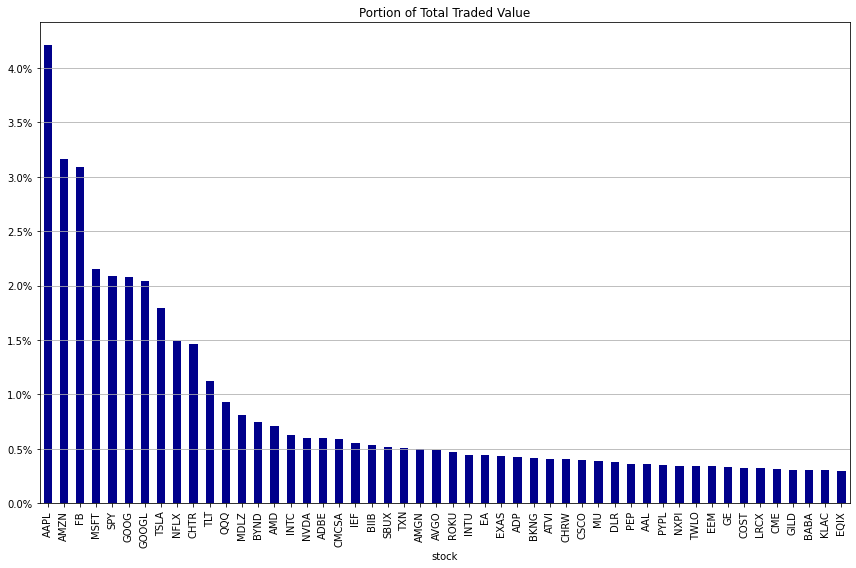

In [83]:
trade_summary.iloc[:50,].plot.bar(figsize=(12,8), color='darkblue', title='Portion of Total Traded Value')
plt.grid(True, which='major', axis='y')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _ : '{:.1%}'.format(y)))
#sns.despine()
plt.tight_layout();